# Detecting Financial Market Regimes
### The Mining Avengers: Blake Krouth, Nandhika Rajmanikandan, Ganesh Vannam

We performed unsupervised market regime detection on S&P 500 historical data using three progressively complex feature sets. Feature Set 1 used the 6-month smoothed cumulative return, Feature Set 2 incorporated smoothed return, rolling volatility, momentum, and a return z-score, and Feature Set 3 used high-frequency indicators including daily returns, 10-day rolling volatility, and 10-day momentum. For each feature set, we applied KMeans clustering, Hidden Markov Models (HMM), Gaussian Mixture Models (GMM), and Fuzzy C-Means (FCM) to identify underlying regimes in market behavior. The models were evaluated using metrics appropriate to their nature: KMeans with silhouette score, Calinski-Harabasz, and Davies-Bouldin indices; HMM and GMM with log-likelihood, AIC, and BIC; and FCM with the fuzzy partition coefficient (FPC). Each model's optimal number of regimes was determined via tuning loops and visual inspection. Finally, we visualized the regime-labeled time series for each model across all feature sets using color-coded scatter plots overlaid on price data to interpret how different models segment the market trends.

### Install Required Libraries
This cell installs the `hmmlearn` and `scikit-fuzzy` packages which are used for Hidden Markov Models (HMM) and fuzzy logic operations, respectively.


In [66]:
!pip install hmmlearn
!pip install scikit-fuzzy

### Import Libraries
This cell imports all necessary Python libraries for data manipulation, visualization, machine learning, and clustering methods including HMMs, fuzzy logic, and Gaussian Mixture Models.


In [67]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from hmmlearn.hmm import GaussianHMM
import skfuzzy as fuzz
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

## 1. Data Acquisition, Preprocessing, and Feature Engineering

We download historical stock market data for the S&P 500 index (ticker symbol: ^GSPC) from Yahoo Finance from January 1, 1990 to January 1, 2024.

This contains the following daily prices:
* Close
* High
* Low
* Open
* Volume


In [68]:
# Obtain historical market data for S&P 500 from January 1, 1990 to January 1, 2024.
start_date = "1990-01-01"
end_date = "2024-01-01"
df_sp500 = yf.download("^GSPC", start=start_date, end=end_date)
df_sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1990-01-02,359.690002,359.690002,351.980011,353.399994,162070000
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000


We are interested in the daily closing prices, so we extract that here. Additionally, the day-to-day percent change, or return is calculated.


In [69]:
# Extract daily closing prices and calculate percent return
price = df_sp500[('Close', '^GSPC')].rename('Price')
df = pd.DataFrame(index=df_sp500.index)
df['Price'] = price
df['Return'] = df['Price'].pct_change()
df.head()

,Price,Return
Date,,
1990-01-02,359.690002,NaN
1990-01-03,358.760010,-0.002586
1990-01-04,355.670013,-0.008613
1990-01-05,352.200012,-0.009756
1990-01-08,353.790009,0.004514


Financial time-series day is very noisy. To reduce noise, we sample the data monthly and engineer the following features:
* The month-to-month return to capture month to month changes
* The cumulative monthly return to capture long-term monthly changes
* The rolling monthly volatility to capture month-to-month stability

Using the monthly features, we further engineer:
* The 6 month rolling cumulative return
* The percent change from the last 3 months
* A z-score calculation comparing the monthly return to the mean and standard devation of the last 12 monthly returns

All NA values are then dropped.


In [70]:
# Monthly resampling
monthly = df.resample('M').last()

# Monthly returns
monthly['MonthlyReturn'] = monthly['Price'].pct_change()
monthly['CumReturn'] = (1 + monthly['MonthlyReturn']).cumprod()

# Monthly volatility
df['Volatility'] = df['Return'].rolling(window=21).std()
monthly['Volatility'] = df['Volatility'].resample('M').last()

# 6-month smoothed return
monthly['SmoothedReturn'] = monthly['CumReturn'].rolling(window=6).mean()

# 6-month rolling volatility
monthly['RollingVol'] = monthly['Volatility'].rolling(window=6).mean()

# 3-month momentum
monthly['Momentum'] = monthly['Price'].pct_change(periods=3)

# Monthly return vs yearly return z-score
monthly['ReturnZ'] = (monthly['MonthlyReturn'] - monthly['MonthlyReturn'].rolling(12).mean()) / monthly['MonthlyReturn'].rolling(12).std()

monthly.dropna(inplace=True)
print(monthly.shape)
monthly.head()

(396, 9)


,Price,Return,MonthlyReturn,CumReturn,Volatility,SmoothedReturn,RollingVol,Momentum,ReturnZ
Date,,,,,,,,,
1991-01-31,343.929993,0.008859,0.041518,1.045126,0.012095,0.976956,0.011733,0.131349,0.738411
1991-02-28,367.070007,-0.001822,0.067281,1.115443,0.010839,0.999499,0.010809,0.139191,1.088464
1991-03-31,375.220001,-0.000346,0.022203,1.140209,0.008239,1.034531,0.010408,0.136273,0.239532
1991-04-30,375.339996,0.004496,0.000320,1.140574,0.009891,1.070662,0.009823,0.091327,-0.222309
1991-05-31,389.829987,0.007417,0.038605,1.184606,0.008311,1.104904,0.009432,0.062004,0.676492


## 2. EDA

We explore the trends and distribution of our engineered features to ensure we were successful at eliminating excessive noise.

First, the monthly features are graphed. There is still noise present, but the overall distribution seems roughly normal with little outliers.

### Plot Monthly Returns

creates a time-series line plot of the **monthly returns** of the S&P 500.

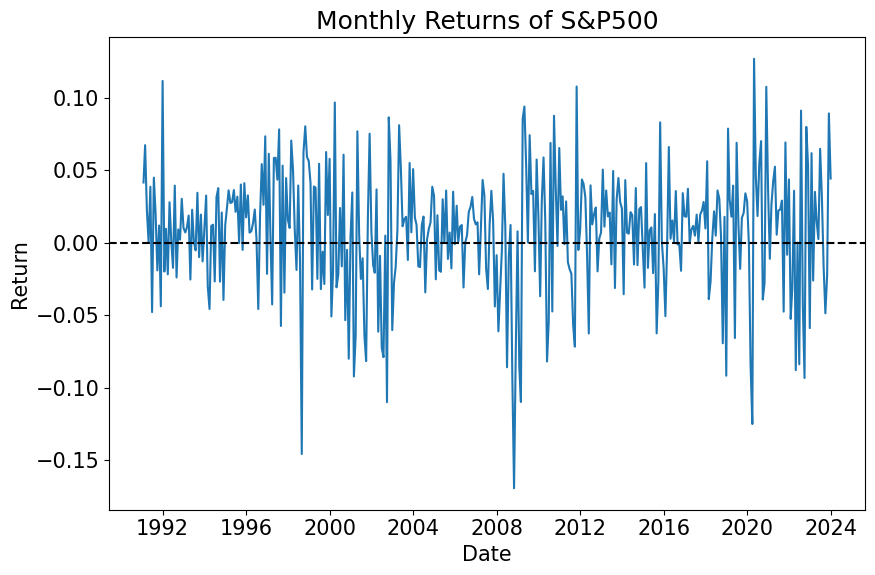

In [71]:
plt.figure(figsize=(9,6))
plt.plot(monthly.index, monthly['MonthlyReturn'], label='Monthly Return')
plt.axhline(0, color='black', linestyle='--')
plt.title('Monthly Returns of S&P500')
plt.xlabel('Date')
plt.ylabel('Return')
plt.tight_layout()
plt.rcParams['font.size'] = 15
plt.show()

### Plot Monthly Volatility
shows the **volatility** of the S&P 500 over time, helping to identify periods of market turbulence.

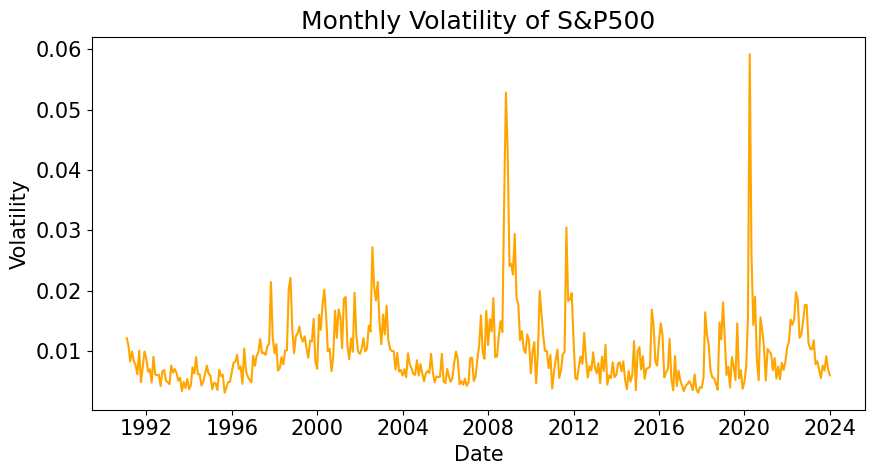

In [72]:
plt.figure(figsize=(9, 5))
plt.plot(monthly.index, monthly['Volatility'], color='orange', label='Monthly Volatility')
plt.title('Monthly Volatility of S&P500')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()

### Plot Cumulative Returns
Displays the **cumulative return** trend over time, showing long-term performance.


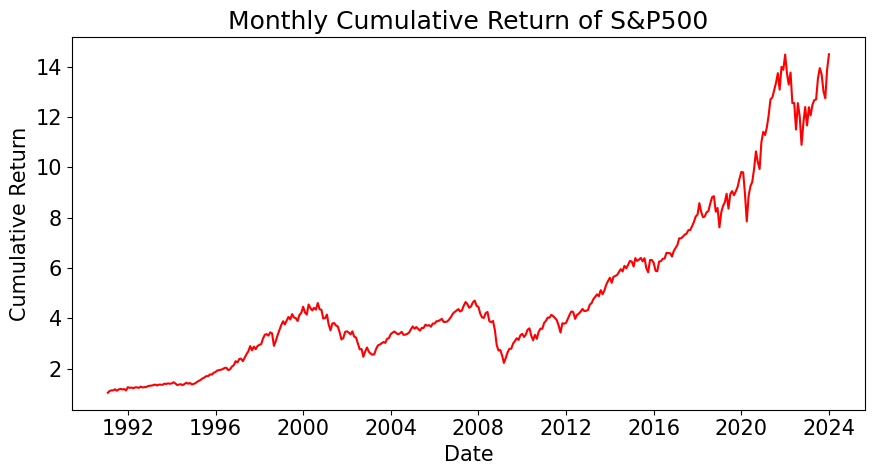

In [73]:
plt.figure(figsize=(9, 5))
plt.plot(monthly.index, monthly['CumReturn'], color='red', label='Monthly Cumulative Return')
plt.title('Monthly Cumulative Return of S&P500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.tight_layout()
plt.show()

### Histogram of Monthly Returns

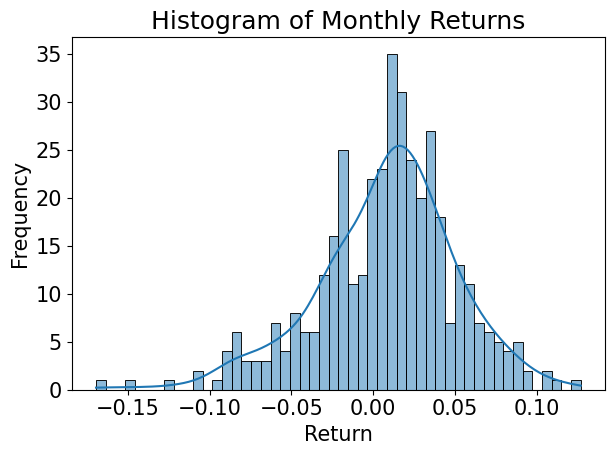

In [74]:
sns.histplot(monthly['MonthlyReturn'], bins=50, kde=True)
plt.title("Histogram of Monthly Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Next, we analyze the distribution of the features that were engineered from the monthly features and observe the following:

* The 6-month cumulative returns are surprisingly noisy and are right skewed
* The 6-month rolling volatility is heavily right skewed
* The 3-month momentum is relatively normally distributed
* The z-score is slightly left skewed

### Histogram of 6-Month Cumulative Returns
Distribution of **6-month smoothed returns** to examine medium-term performance.

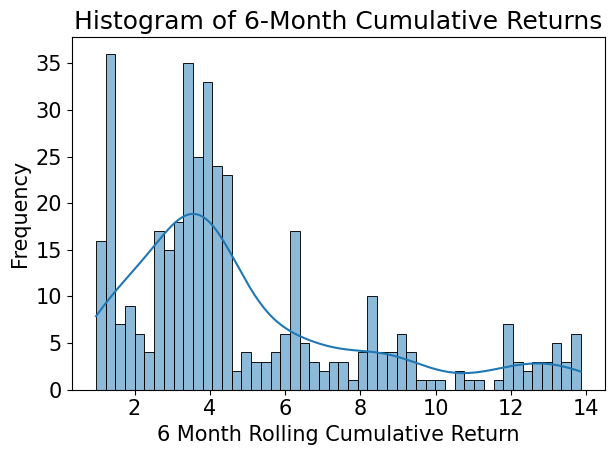

In [75]:
sns.histplot(monthly['SmoothedReturn'], bins=50, kde=True)
plt.title("Histogram of 6-Month Cumulative Returns")
plt.xlabel("6 Month Rolling Cumulative Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Histogram of 6-Month Rolling Volatility


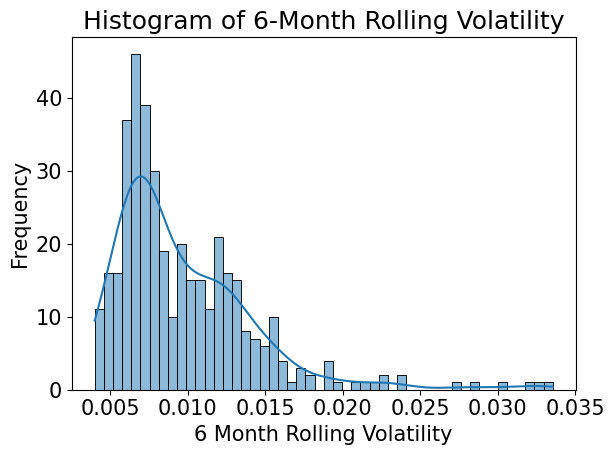

In [76]:
sns.histplot(monthly['RollingVol'], bins=50, kde=True)
plt.title("Histogram of 6-Month Rolling Volatility")
plt.xlabel("6 Month Rolling Volatility")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###  Histogram of 3-Month Momentum

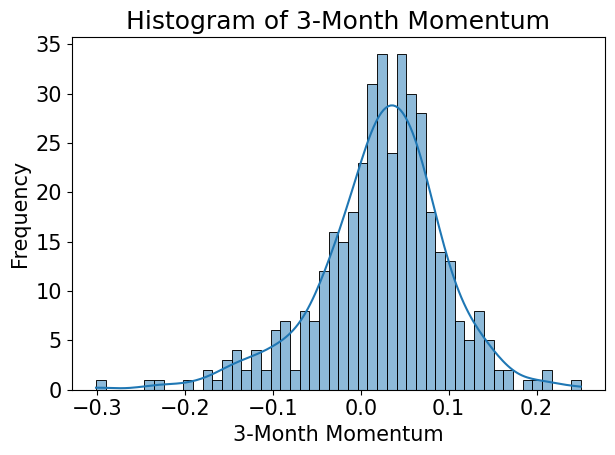

In [77]:
sns.histplot(monthly['Momentum'], bins=50, kde=True)
plt.title("Histogram of 3-Month Momentum")
plt.xlabel("3-Month Momentum")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Histogram of Return Z-Scores

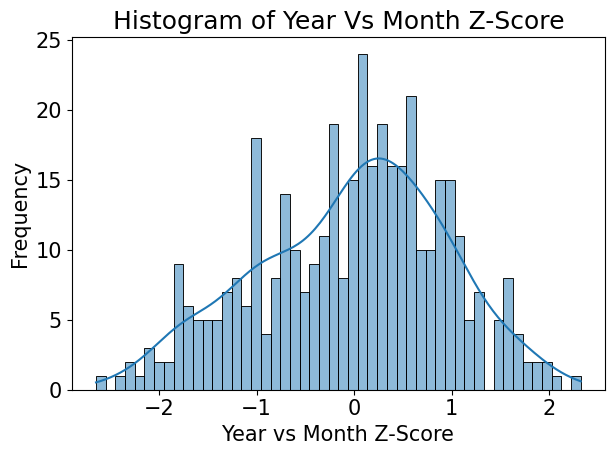

In [78]:
sns.histplot(monthly['ReturnZ'], bins=50, kde=True)
plt.title("Histogram of Year Vs Month Z-Score")
plt.xlabel("Year vs Month Z-Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 3. Clustering with Feature Set 1

First, we evaluate models with only one feature:
* the 6-month rolling average of cumulative returns.

By doing this, we gain insight into how the models behave in general, which we can apply to higher feature spaces.

In [79]:
CHOSEN_FEATURE = 'SmoothedReturn'
feature_set_1 = pd.DataFrame(monthly[CHOSEN_FEATURE])
feature_set_1.head()

,SmoothedReturn
Date,
1991-01-31,0.976956
1991-02-28,0.999499
1991-03-31,1.034531
1991-04-30,1.070662
1991-05-31,1.104904


### Standardize Data
This cell standardizes the features using `StandardScaler` from scikit-learn.

In [80]:
# Scale data
feature_set_1_scaler = StandardScaler()
feature_set_1_scaled = feature_set_1_scaler.fit_transform(feature_set_1)
print(feature_set_1_scaled[:5])

[[-1.20254521]
 [-1.19556888]
 [-1.18472744]
 [-1.17354588]
 [-1.16294895]]



## K-means on Feature set 1

Finds the optimal number of clusters (`k`) using **Silhouette Score**, and assigns market regimes accordingly.


In [81]:
best_kmeans = None
best_score = -1
best_k = 0

for k in range(3, 10):
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = kmeans_tmp.fit_predict(feature_set_1_scaled)
    score = silhouette_score(feature_set_1_scaled, labels_tmp)
    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = kmeans_tmp

monthly.loc[feature_set_1.index, 'Regime_Return'] = best_kmeans.predict(feature_set_1_scaled)
print(f"[INFO] Best KMeans k={best_k} with Silhouette Score={best_score:.2f}")

[INFO] Best KMeans k=5 with Silhouette Score=0.66


### Visualize KMeans Regimes Over Time
Color-coded bands to indicate detected regimes over time, alongside the smoothed return line.

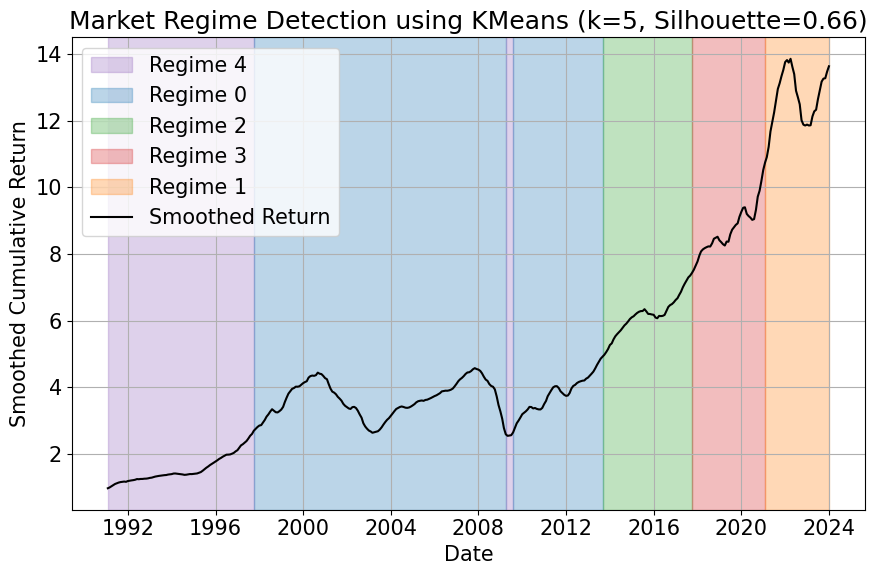

In [82]:
# --- Set up color palette for regimes ---
num_clusters = best_k
palette = sns.color_palette("tab10", num_clusters)
color_map = {i: palette[i] for i in range(num_clusters)}
monthly['RegimeColor'] = monthly['Regime_Return'].map(color_map)

# --- Plot regimes over time ---
fig, ax = plt.subplots(figsize=(9, 6))

# Plot regime blocks
prev_regime = monthly['Regime_Return'].dropna().iloc[0]
start_date = monthly['Regime_Return'].dropna().index[0]

plotted_labels = set()
for date, regime in monthly['Regime_Return'].dropna().items():
    if regime != prev_regime:
        label = f"Regime {int(prev_regime)}" if prev_regime not in plotted_labels else None
        ax.axvspan(start_date, date, color=color_map[prev_regime], alpha=0.3, label=label)
        plotted_labels.add(prev_regime)
        start_date = date
        prev_regime = regime
# Final block
label = f"Regime {int(prev_regime)}" if prev_regime not in plotted_labels else None
ax.axvspan(start_date, monthly['Regime_Return'].index[-1], color=color_map[prev_regime], alpha=0.3, label=label)

# Plot the smoothed return for reference
ax.plot(feature_set_1.index, feature_set_1['SmoothedReturn'], color='black', linewidth=1.5, label='Smoothed Return')

# Beautify the plot
ax.set_title(f"Market Regime Detection using KMeans (k={best_k}, Silhouette={best_score:.2f})")
ax.set_xlabel("Date")
ax.set_ylabel("Smoothed Cumulative Return")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## Hidden Markov Model (HMM) on Feature set 1

Fits a **Hidden Markov Model (HMM)** to the same feature, tuning for the best number of hidden states using log-likelihood.

In [83]:
# --- 2. HMM Tuning (Try different number of hidden states) ---
print("[INFO] Tuning HMM on Smoothed Return...")

X = feature_set_1.values
X_scaled = feature_set_1_scaler.fit_transform(X)

best_hmm = None
best_k = 0
best_score = -np.inf
log_likelihoods = []
aics = []
bics = []

for k in range(2, 7):
    model = GaussianHMM(n_components=k, covariance_type='full', random_state=42, n_iter=500)
    model.fit(X_scaled)
    log_likelihood = model.score(X_scaled)
    aic = -2 * log_likelihood + 2 * k * (X_scaled.shape[1] + X_scaled.shape[1]**2 + 1)
    bic = -2 * log_likelihood + np.log(len(X_scaled)) * k * (X_scaled.shape[1] + X_scaled.shape[1]**2 + 1)

    log_likelihoods.append(log_likelihood)
    aics.append(aic)
    bics.append(bic)

    if log_likelihood > best_score:
        best_score = log_likelihood
        best_k = k
        best_hmm = model

print(f"\n✅ Best HMM k={best_k} with log-likelihood={best_score:.2f}")

[INFO] Tuning HMM on Smoothed Return...

✅ Best HMM k=4 with log-likelihood=58.74


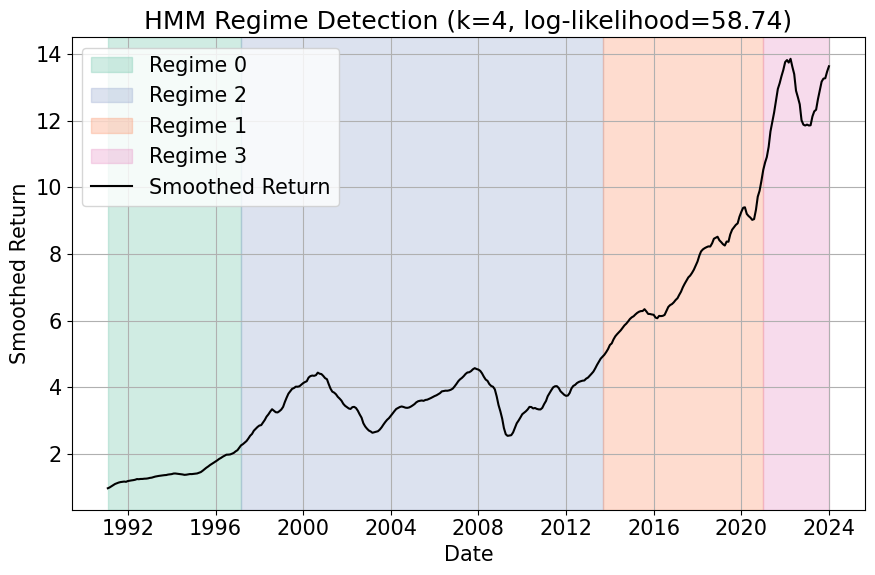

In [84]:
# --- 3. Predict Regimes ---
hmm_labels = best_hmm.predict(X_scaled)
monthly.loc[feature_set_1.index, 'Regime_HMM'] = hmm_labels

# --- 4. Visualize Regimes Over Time ---
palette = sns.color_palette("Set2", best_k)
color_map = {i: palette[i] for i in range(best_k)}
monthly['Regime_HMM_Color'] = monthly['Regime_HMM'].map(color_map)

fig, ax = plt.subplots(figsize=(9, 6))

prev_regime = monthly['Regime_HMM'].dropna().iloc[0]
start_date = monthly['Regime_HMM'].dropna().index[0]

plotted_labels = set()
for date, regime in monthly['Regime_HMM'].dropna().items():
    if regime != prev_regime:
        label = f"Regime {int(prev_regime)}" if prev_regime not in plotted_labels else None
        ax.axvspan(start_date, date, color=color_map[prev_regime], alpha=0.3, label=label)
        plotted_labels.add(prev_regime)
        start_date = date
        prev_regime = regime
# Final block
label = f"Regime {int(prev_regime)}" if prev_regime not in plotted_labels else None
ax.axvspan(start_date, monthly['Regime_HMM'].dropna().index[-1], color=color_map[prev_regime], alpha=0.3, label=label)

# Smoothed return overlay
ax.plot(feature_set_1.index, feature_set_1['SmoothedReturn'], color='black', linewidth=1.5, label='Smoothed Return')
ax.set_title(f"HMM Regime Detection (k={best_k}, log-likelihood={best_score:.2f})")
ax.set_xlabel("Date")
ax.set_ylabel("Smoothed Return")
ax.grid(True)
ax.legend(loc='upper left')
plt.tight_layout()

plt.show()

## Fuzzy C-Means (FCM) on Feature set 1

Installs the `scikit-fuzzy` package for future fuzzy clustering analysis.

In [85]:
!pip install scikit-fuzzy

Applied **Fuzzy C-Means clustering** to assign soft membership-based regimes to each data point. Creates a new column `Fuzzy_Regime` for the output.

[INFO] Tuning Fuzzy C-Means...

✅ Best Fuzzy C-Means k=3 with FPC=0.8339


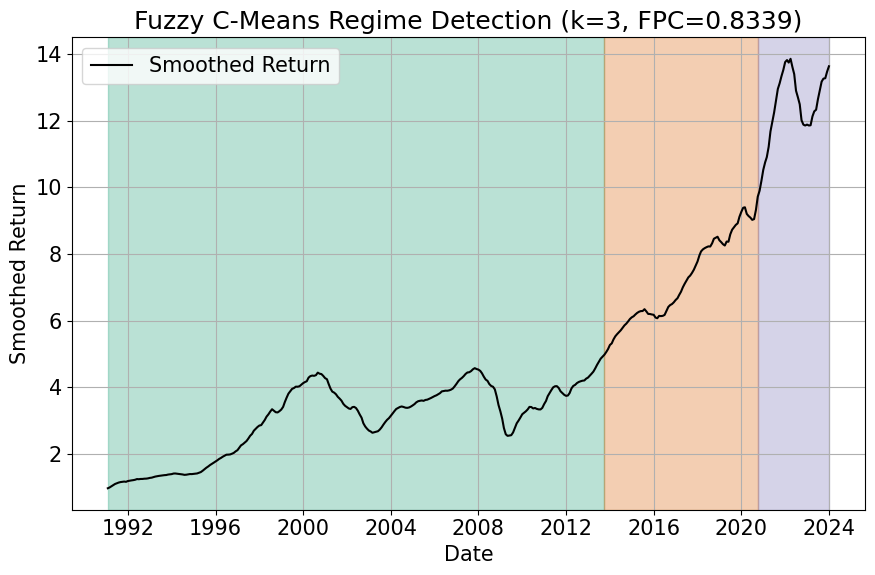

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

# --- 1. Prepare Feature (same as before) ---
X = monthly[['SmoothedReturn']].values.T  # FCM expects shape (features, samples)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.T).T

# --- 2. Tune FCM: Try different number of clusters ---
fpcs = []
best_n_clusters = None
best_fpc = -1
best_membership = None
best_labels = None
best_cntr = None

print("[INFO] Tuning Fuzzy C-Means...")
for n_clusters in range(3, 8):
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_scaled, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpcs.append(fpc)

    if fpc > best_fpc:
        best_fpc = fpc
        best_n_clusters = n_clusters
        best_membership = u
        best_cntr = cntr

# --- 3. Assign hard cluster labels based on max membership ---
fcm_labels = np.argmax(best_membership, axis=0)
monthly.loc[monthly.index, 'Regime_FCM'] = fcm_labels
print(f"\n✅ Best Fuzzy C-Means k={best_n_clusters} with FPC={best_fpc:.4f}")

# --- 4. Visualize Clusters Over Time ---
palette = sns.color_palette("Dark2", best_n_clusters)
color_map = {i: palette[i] for i in range(best_n_clusters)}
monthly['Regime_FCM_Color'] = monthly['Regime_FCM'].map(color_map)

fig, ax = plt.subplots(figsize=(9, 6))

prev_regime = monthly['Regime_FCM'].dropna().iloc[0]
start_date = monthly['Regime_FCM'].dropna().index[0]

for date, regime in monthly['Regime_FCM'].dropna().items():
    if regime != prev_regime:
        ax.axvspan(start_date, date, color=color_map[prev_regime], alpha=0.3)
        start_date = date
        prev_regime = regime
# Final block
ax.axvspan(start_date, monthly['Regime_FCM'].dropna().index[-1], color=color_map[prev_regime], alpha=0.3)

# Plot Smoothed Return
ax.plot(monthly.index, monthly['SmoothedReturn'], color='black', linewidth=1.5, label='Smoothed Return')
ax.set_title(f"Fuzzy C-Means Regime Detection (k={best_n_clusters}, FPC={best_fpc:.4f})")
ax.set_xlabel("Date")
ax.set_ylabel("Smoothed Return")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## Gaussian Mixture Model (GMM) on Feature set 1

[INFO] Tuning GMM on Smoothed Return...

✅ Best GMM k=5 with Log-Likelihood=-370.53 and BIC=824.81


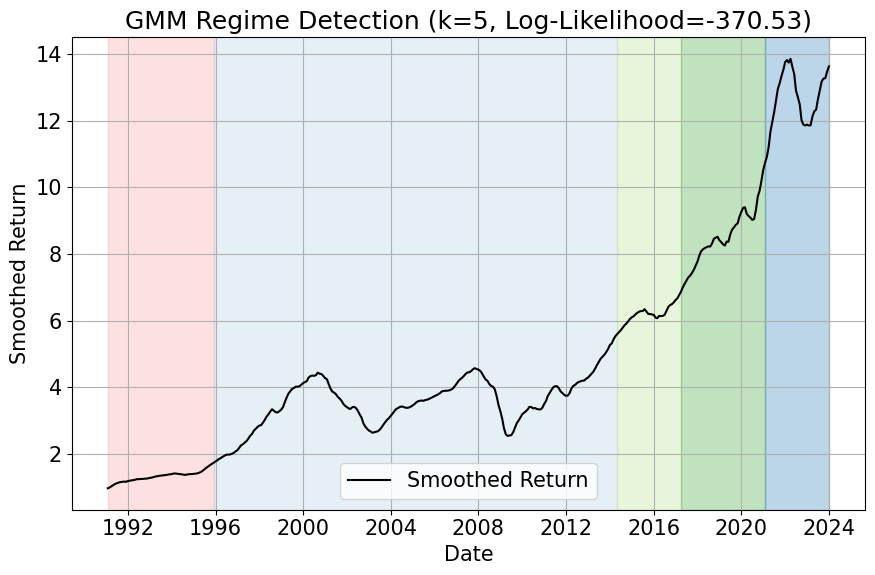

In [87]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- 1. Prepare Feature ---
X = monthly[['SmoothedReturn']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Tune GMM: Try different number of components ---
lowest_bic = np.inf
best_gmm = None
bic = []
aic = []
log_likelihoods = []
n_components_range = range(2, 8)

print("[INFO] Tuning GMM on Smoothed Return...")

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    ll = gmm.score(X_scaled) * len(X_scaled)
    l_bic = gmm.bic(X_scaled)
    l_aic = gmm.aic(X_scaled)

    bic.append(l_bic)
    aic.append(l_aic)
    log_likelihoods.append(ll)

    if l_bic < lowest_bic:
        lowest_bic = l_bic
        best_gmm = gmm
        best_k = n_components
        best_ll = ll

# --- 3. Predict Regimes ---
gmm_labels = best_gmm.predict(X_scaled)
monthly['Regime_GMM'] = gmm_labels

print(f"\n✅ Best GMM k={best_k} with Log-Likelihood={best_ll:.2f} and BIC={lowest_bic:.2f}")

# --- 4. Visualize Clusters Over Time ---
palette = sns.color_palette("Paired", best_k)
color_map = {i: palette[i] for i in range(best_k)}
monthly['Regime_GMM_Color'] = monthly['Regime_GMM'].map(color_map)

fig, ax = plt.subplots(figsize=(9, 6))

prev_regime = monthly['Regime_GMM'].dropna().iloc[0]
start_date = monthly['Regime_GMM'].dropna().index[0]

for date, regime in monthly['Regime_GMM'].dropna().items():
    if regime != prev_regime:
        ax.axvspan(start_date, date, color=color_map[prev_regime], alpha=0.3)
        start_date = date
        prev_regime = regime
ax.axvspan(start_date, monthly['Regime_GMM'].dropna().index[-1], color=color_map[prev_regime], alpha=0.3)

# Plot Smoothed Return for reference
ax.plot(monthly.index, monthly['SmoothedReturn'], color='black', linewidth=1.5, label='Smoothed Return')
ax.set_title(f"GMM Regime Detection (k={best_k}, Log-Likelihood={best_ll:.2f})")
ax.set_xlabel("Date")
ax.set_ylabel("Smoothed Return")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


# 4. Clustering with Feature Set 2

**Feature Set 2** using the columns: Rolling Volatility, 3-Month Momentum, and Return Z-Score.

In [88]:
from sklearn.preprocessing import StandardScaler

# Define Feature Set 2
feature_set_2 = monthly[['RollingVol', 'Momentum', 'ReturnZ']].copy()

# Standardize the data
scaler = StandardScaler()
feature_set_2_scaled = scaler.fit_transform(feature_set_2)

print("✅ Feature Set 2 is ready and scaled. Shape:", feature_set_2_scaled.shape)


✅ Feature Set 2 is ready and scaled. Shape: (396, 3)


##  K-means on Feature set 2
performs **KMeans clustering** using the second feature set (`RollingVol`, `Momentum`, `ReturnZ`):

- Tries cluster counts (`k`) from 2 to 9.
- Chooses the best `k` based on the **Silhouette Score**.
- Assigns the resulting cluster labels to a new column: `Regime_KMeans_F2`.

It then visualizes the clusters using a scatter plot over time, showing how market regimes (clusters) evolved based on the selected features.

✅ KMeans on Feature Set 2: k=3, Silhouette=0.35


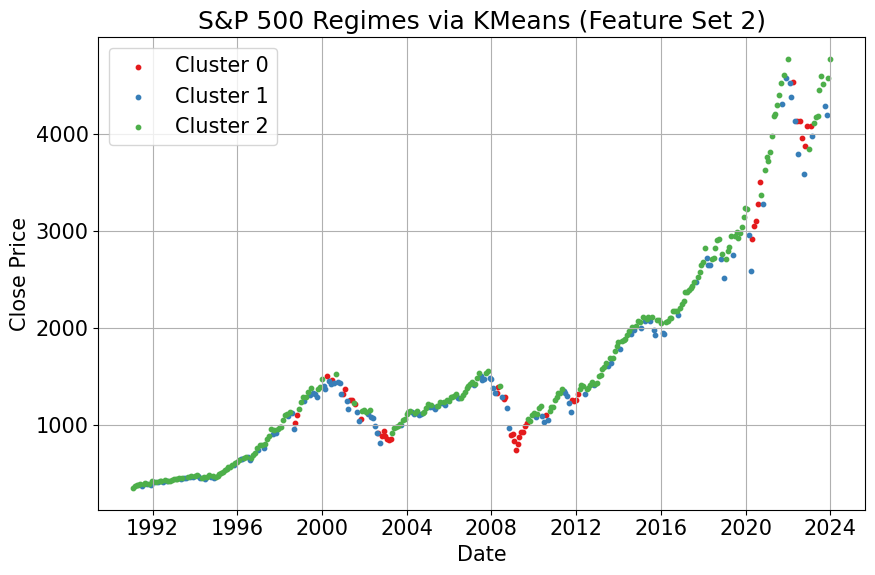

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_kmeans = None
best_score = -1
best_k = 0

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(feature_set_2_scaled)
    score = silhouette_score(feature_set_2_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = kmeans

monthly['Regime_KMeans_F2'] = best_kmeans.predict(feature_set_2_scaled)
print(f"✅ KMeans on Feature Set 2: k={best_k}, Silhouette={best_score:.2f}")

fig, ax = plt.subplots(figsize=(9, 6))

# Color map
palette = sns.color_palette("Set1", monthly['Regime_KMeans_F2'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

# Scatter plot with regime colors
for regime in sorted(monthly['Regime_KMeans_F2'].unique()):
    regime_data = monthly[monthly['Regime_KMeans_F2'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Cluster {regime}', s=10)

ax.set_title("S&P 500 Regimes via KMeans (Feature Set 2)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



##  Hidden Markov Model (HMM) on Feature set 2

Performs **Gaussian Hidden Markov Model** to detect market regimes using Feature Set 2:

- Tries HMMs with 2 to 6 hidden states.
- Selects the best model based on **log-likelihood**.
- Adds predicted regimes as `Regime_HMM_F2`.


✅ HMM on Feature Set 2: k=6, Log-Likelihood=-1042.51


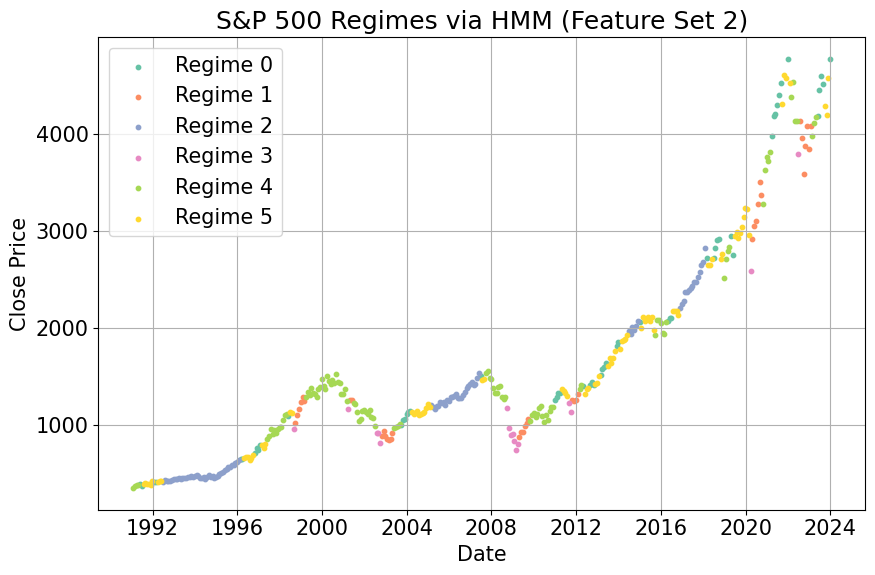

In [90]:
from hmmlearn.hmm import GaussianHMM
import numpy as np

best_hmm = None
best_k = 0
best_score = -np.inf
n_states_range = range(2, 7)

for k in n_states_range:
    model = GaussianHMM(n_components=k, covariance_type='full', random_state=42, n_iter=500)
    model.fit(feature_set_2_scaled)
    log_likelihood = model.score(feature_set_2_scaled)
    if log_likelihood > best_score:
        best_score = log_likelihood
        best_k = k
        best_hmm = model

monthly['Regime_HMM_F2'] = best_hmm.predict(feature_set_2_scaled)
print(f"✅ HMM on Feature Set 2: k={best_k}, Log-Likelihood={best_score:.2f}")
fig, ax = plt.subplots(figsize=(9, 6))

palette = sns.color_palette("Set2", monthly['Regime_HMM_F2'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

for regime in sorted(monthly['Regime_HMM_F2'].unique()):
    regime_data = monthly[monthly['Regime_HMM_F2'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=10)

ax.set_title("S&P 500 Regimes via HMM (Feature Set 2)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



## Fuzzy C-Means (FCM) on Feature set 2
Applies **Fuzzy C-Means clustering** on the Feature Set 2:

- Tests cluster counts from 3 to 7.
- Picks the best model using **Fuzzy Partition Coefficient (FPC)**.
- Assigns each point to the cluster with highest membership (`Regime_FCM_F2`).

✅ Fuzzy C-Means on Feature Set 2: k=3, FPC=0.5261


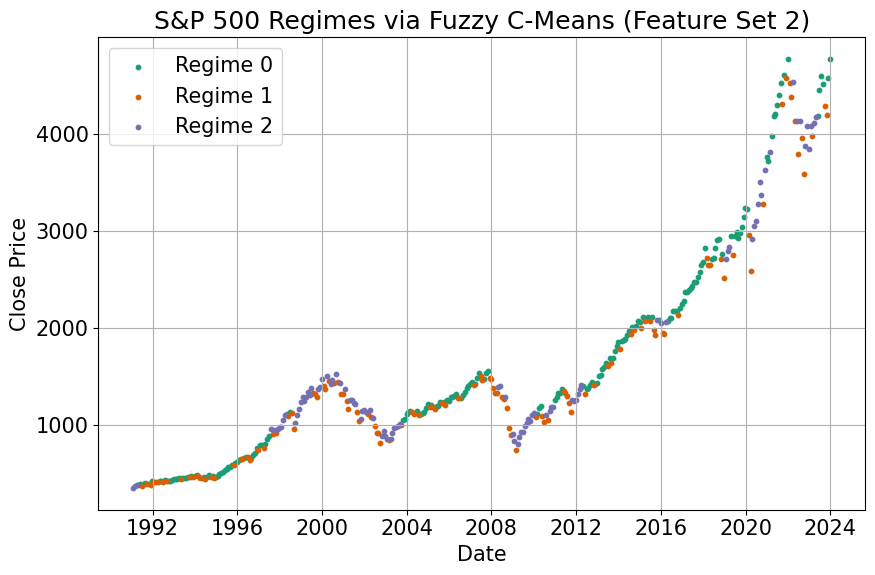

In [91]:
import skfuzzy as fuzz

X_fcm = feature_set_2_scaled.T  # shape: (features, samples)
best_fpc = -1
best_labels = None
best_k = None

for k in range(3, 8):
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_fcm, c=k, m=2.0, error=0.005, maxiter=1000, seed=42
    )
    if fpc > best_fpc:
        best_fpc = fpc
        best_labels = np.argmax(u, axis=0)
        best_k = k

monthly['Regime_FCM_F2'] = best_labels
print(f"✅ Fuzzy C-Means on Feature Set 2: k={best_k}, FPC={best_fpc:.4f}")
fig, ax = plt.subplots(figsize=(9, 6))

palette = sns.color_palette("Dark2", monthly['Regime_FCM_F2'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

for regime in sorted(monthly['Regime_FCM_F2'].unique()):
    regime_data = monthly[monthly['Regime_FCM_F2'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=10)

ax.set_title("S&P 500 Regimes via Fuzzy C-Means (Feature Set 2)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



## Gaussian Mixture Model (GMM) on Feature set 2
**Gaussian Mixture Model** to uncover regimes based on Feature Set 2:

- Tries different component counts (2 to 7).
- Selects the best model using the **Bayesian Information Criterion (BIC)**.
- Stores predicted cluster labels in `Regime_GMM_F2`.

✅ GMM on Feature Set 2: k=4, BIC=3073.48


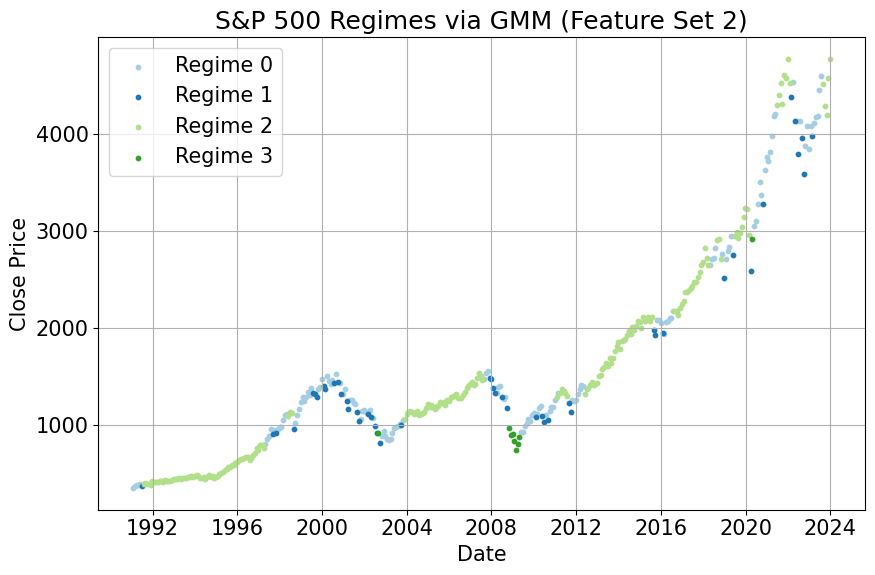

In [92]:
from sklearn.mixture import GaussianMixture

lowest_bic = np.inf
best_gmm = None
n_components_range = range(2, 8)

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(feature_set_2_scaled)
    bic = gmm.bic(feature_set_2_scaled)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

monthly['Regime_GMM_F2'] = best_gmm.predict(feature_set_2_scaled)
print(f"✅ GMM on Feature Set 2: k={best_k}, BIC={lowest_bic:.2f}")
fig, ax = plt.subplots(figsize=(9, 6))

palette = sns.color_palette("Paired", monthly['Regime_GMM_F2'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

for regime in sorted(monthly['Regime_GMM_F2'].unique()):
    regime_data = monthly[monthly['Regime_GMM_F2'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=10)

ax.set_title("S&P 500 Regimes via GMM (Feature Set 2)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



###  Regime Comparison: All Models on Feature Set 2

Creates a **grid of scatter plots** to compare the market regimes identified by:

1. **KMeans**
2. **HMM (Hidden Markov Model)**
3. **Fuzzy C-Means**
4. **Gaussian Mixture Model**

Each subplot shows how the S&P 500 price is segmented over time based on clustering from **Feature Set 2**. Color palettes differ for clarity, helping to visually assess how models diverge or align in their regime detection.


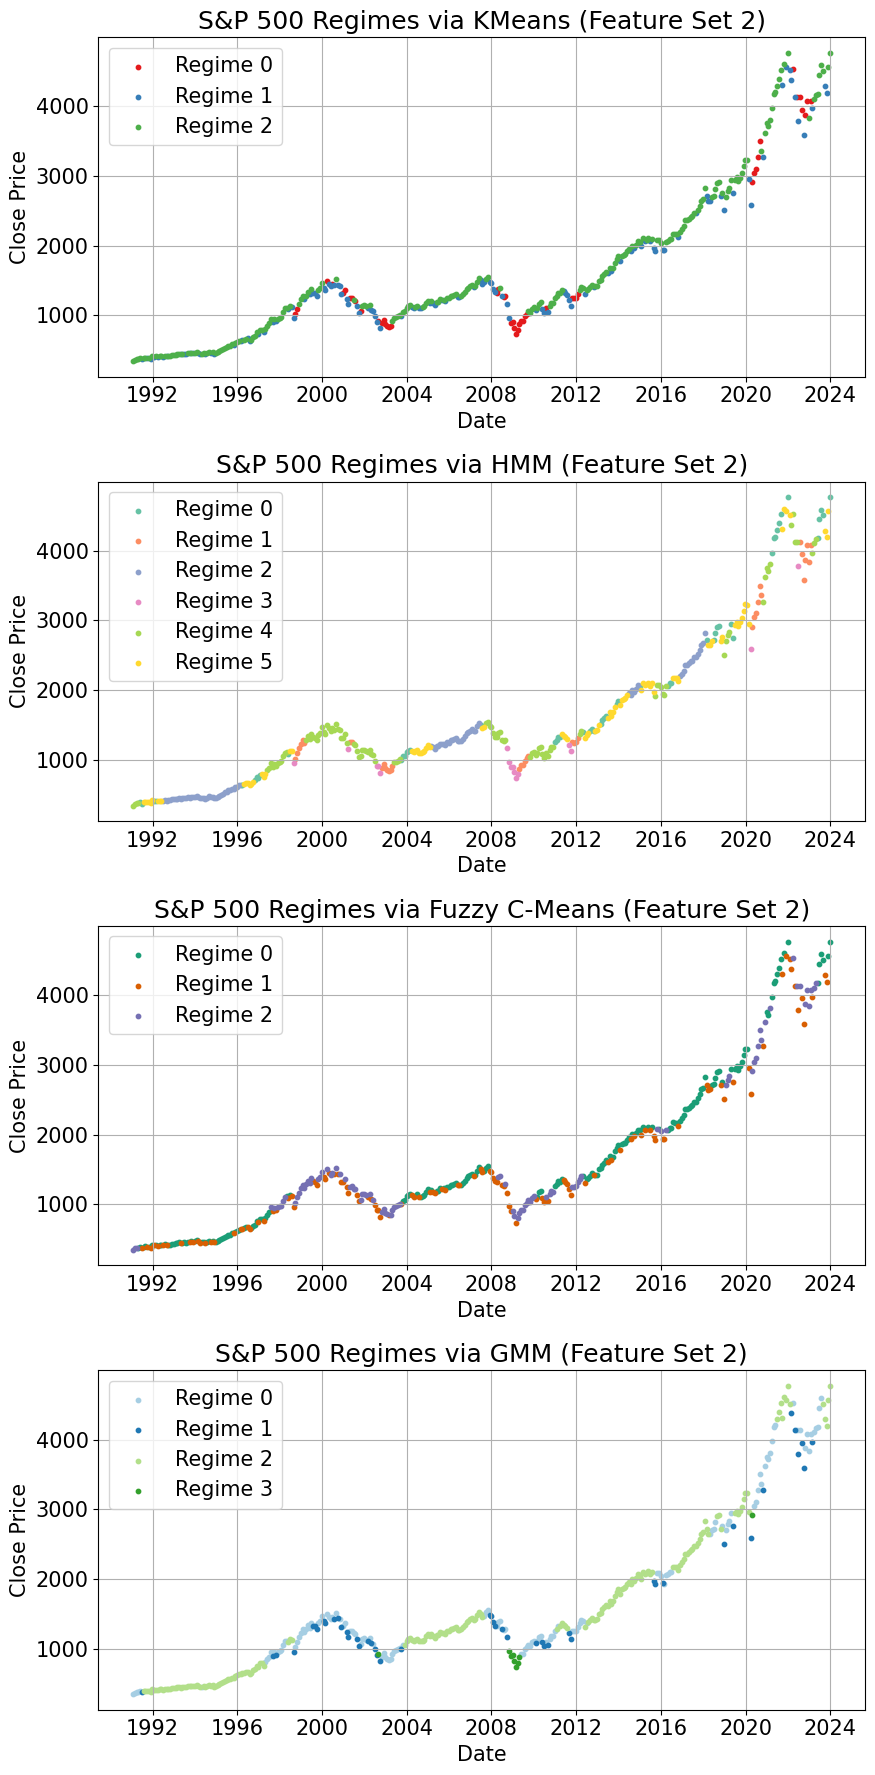

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(4, 1, figsize=(9, 18))
axs = axs.flatten()  # Flatten the 2x2 axes for easy looping

# Define clustering columns and titles
regime_columns = [
    ('Regime_KMeans_F2', 'KMeans (Feature Set 2)', "Set1"),
    ('Regime_HMM_F2', 'HMM (Feature Set 2)', "Set2"),
    ('Regime_FCM_F2', 'Fuzzy C-Means (Feature Set 2)', "Dark2"),
    ('Regime_GMM_F2', 'GMM (Feature Set 2)', "Paired"),
]

for ax, (col, title, palette_name) in zip(axs, regime_columns):
    unique_regimes = sorted(monthly[col].dropna().unique())
    palette = sns.color_palette(palette_name, len(unique_regimes))
    color_map = {regime: palette[i] for i, regime in enumerate(unique_regimes)}

    for regime in unique_regimes:
        regime_data = monthly[monthly[col] == regime]
        ax.scatter(regime_data.index, regime_data['Price'],
                   color=color_map[regime], label=f'Regime {regime}', s=10)

    ax.set_title(f"S&P 500 Regimes via {title}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Feature Set 3

In [94]:
# Step 1: Compute daily features
df_fs3 = df.copy()
df_fs3['Return'] = df_fs3['Price'].pct_change()
df_fs3['Volatility'] = df_fs3['Return'].rolling(window=10).std()
df_fs3['Momentum'] = df_fs3['Price'].pct_change(periods=10)

# Drop NaNs
df_fs3.dropna(inplace=True)

# Select feature set
feature_set_3 = df_fs3[['Return', 'Volatility', 'Momentum']]
scaler = StandardScaler()
feature_set_3_scaled = scaler.fit_transform(feature_set_3)


##  K-**Means** on Feature Set 3

Runs KMeans for k = 2 to 10 and picks the best using **Silhouette Score**.  
Also shows **Calinski-Harabasz** and **Davies-Bouldin** scores.  
Plots both the tuning curve and regime segmentation on price chart.


✅ KMeans (Feature Set 3) k=2
Silhouette Score: 0.411
Calinski-Harabasz Index: 2850.23
Davies-Bouldin Index: 1.271


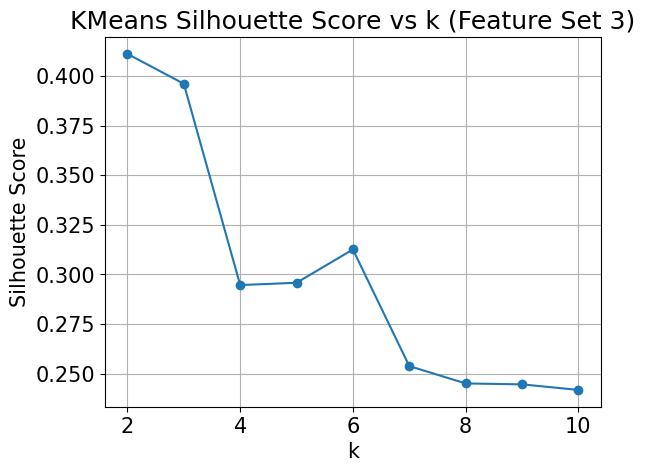

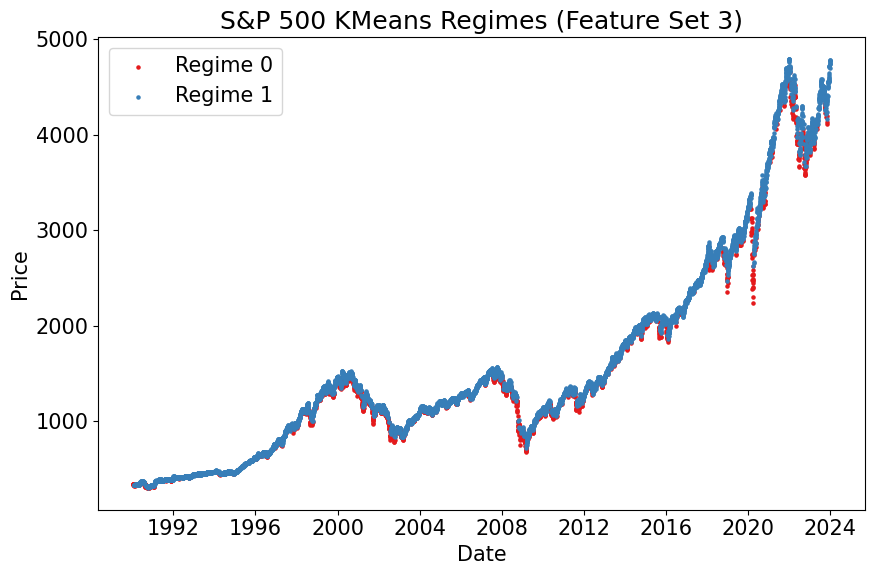

In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

best_kmeans = None
best_k = None
best_score = -1
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(feature_set_3_scaled)
    score = silhouette_score(feature_set_3_scaled, labels)
    sil_scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = kmeans

# Assign final cluster labels
df_fs3['Regime_KMeans'] = best_kmeans.predict(feature_set_3_scaled)

# Evaluation
ch_index = calinski_harabasz_score(feature_set_3_scaled, df_fs3['Regime_KMeans'])
db_index = davies_bouldin_score(feature_set_3_scaled, df_fs3['Regime_KMeans'])

print(f"✅ KMeans (Feature Set 3) k={best_k}")
print(f"Silhouette Score: {best_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

# Plot silhouette tuning
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("KMeans Silhouette Score vs k (Feature Set 3)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

palette = sns.color_palette("Set1", df_fs3['Regime_KMeans'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

fig, ax = plt.subplots(figsize=(9, 6))
for regime in sorted(df_fs3['Regime_KMeans'].unique()):
    regime_data = df_fs3[df_fs3['Regime_KMeans'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=5)

ax.set_title("S&P 500 KMeans Regimes (Feature Set 3)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()


##  Fuzzy C-Means on Feature Set 3

Tests clusters from k = 2 to 7, picks best using **Fuzzy Partition Coefficient (FPC)**.  
Assigns soft clusters and visualizes regimes on the price timeline.

✅ Fuzzy C-Means (Feature Set 3) k=2
Fuzzy Partition Coefficient (FPC): 0.6603


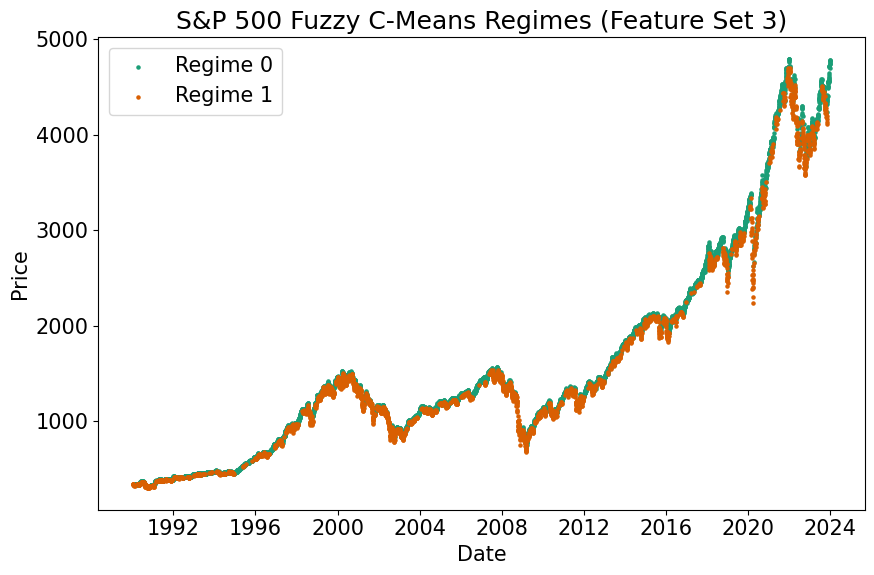

In [96]:
import skfuzzy as fuzz

X_fcm = feature_set_3_scaled.T
best_fpc = -1
best_labels = None
best_k = None

for k in range(2, 8):
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_fcm, c=k, m=2.0, error=0.005, maxiter=1000, seed=42
    )
    if fpc > best_fpc:
        best_fpc = fpc
        best_labels = np.argmax(u, axis=0)
        best_k = k

df_fs3['Regime_FCM'] = best_labels

print(f"✅ Fuzzy C-Means (Feature Set 3) k={best_k}")
print(f"Fuzzy Partition Coefficient (FPC): {best_fpc:.4f}")
palette = sns.color_palette("Dark2", df_fs3['Regime_FCM'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

fig, ax = plt.subplots(figsize=(9, 6))
for regime in sorted(df_fs3['Regime_FCM'].unique()):
    regime_data = df_fs3[df_fs3['Regime_FCM'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=5)

ax.set_title("S&P 500 Fuzzy C-Means Regimes (Feature Set 3)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()



## HMM on Feature Set 3

Fits HMMs with 2–6 states and selects the best based on **log-likelihood**.  
Also tracks AIC and BIC for model comparison.  
Visualizes predicted regimes over time

✅ HMM (Feature Set 3) k=6
Log-Likelihood: -18455.86
AIC: 37067.73
BIC: 37617.96


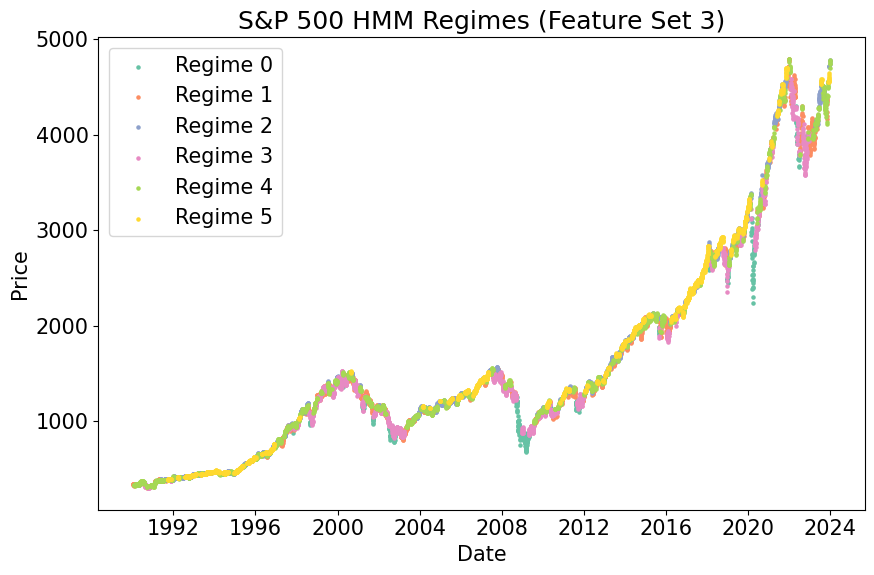

In [97]:
from hmmlearn.hmm import GaussianHMM
import numpy as np

best_score = -np.inf
best_model = None
best_k = None
aics, bics, lls = [], [], []

for k in range(2, 7):
    model = GaussianHMM(n_components=k, covariance_type='full', n_iter=500, random_state=42)
    model.fit(feature_set_3_scaled)
    ll = model.score(feature_set_3_scaled)
    aic = -2 * ll + 2 * k * (feature_set_3_scaled.shape[1] + feature_set_3_scaled.shape[1]**2 + 1)
    bic = -2 * ll + np.log(len(feature_set_3_scaled)) * k * (feature_set_3_scaled.shape[1] + feature_set_3_scaled.shape[1]**2 + 1)

    aics.append(aic)
    bics.append(bic)
    lls.append(ll)

    if ll > best_score:
        best_score = ll
        best_model = model
        best_k = k

df_fs3['Regime_HMM'] = best_model.predict(feature_set_3_scaled)

print(f"✅ HMM (Feature Set 3) k={best_k}")
print(f"Log-Likelihood: {best_score:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
palette = sns.color_palette("Set2", df_fs3['Regime_HMM'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

fig, ax = plt.subplots(figsize=(9, 6))
for regime in sorted(df_fs3['Regime_HMM'].unique()):
    regime_data = df_fs3[df_fs3['Regime_HMM'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=5)

ax.set_title("S&P 500 HMM Regimes (Feature Set 3)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()



## GMM on Feature Set 3

Fits Gaussian Mixture Models for k = 2 to 7.  
Selects best model using **BIC** and plots the regimes over time.

✅ GMM (Feature Set 3) k=7
BIC: 56369.47
Log-Likelihood: -27872.36


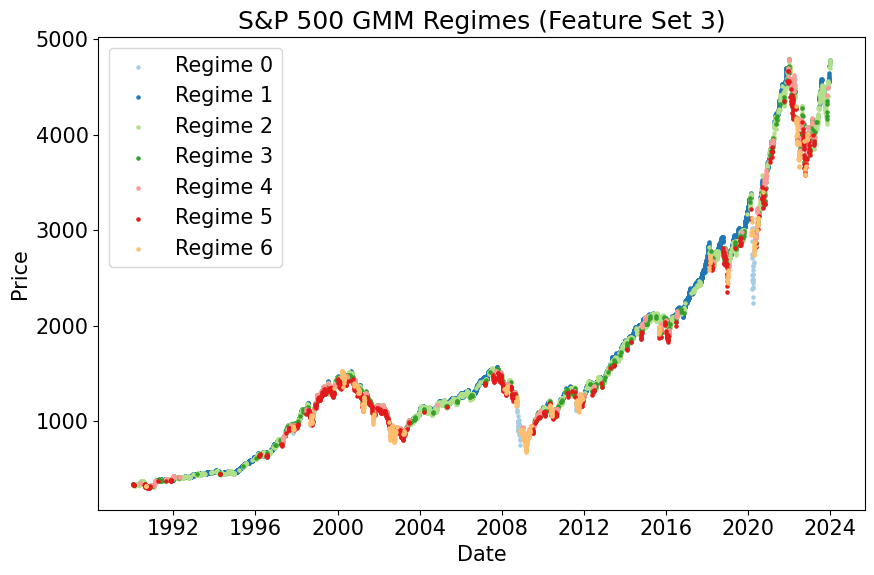

In [98]:
from sklearn.mixture import GaussianMixture

lowest_bic = np.inf
best_gmm = None
best_k = None

for k in range(2, 8):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(feature_set_3_scaled)
    bic = gmm.bic(feature_set_3_scaled)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

df_fs3['Regime_GMM'] = best_gmm.predict(feature_set_3_scaled)

print(f"✅ GMM (Feature Set 3) k={best_k}")
print(f"BIC: {lowest_bic:.2f}")
print(f"Log-Likelihood: {best_gmm.score(feature_set_3_scaled) * len(feature_set_3_scaled):.2f}")
palette = sns.color_palette("Paired", df_fs3['Regime_GMM'].nunique())
color_map = {i: palette[i] for i in range(len(palette))}

fig, ax = plt.subplots(figsize=(9, 6))
for regime in sorted(df_fs3['Regime_GMM'].unique()):
    regime_data = df_fs3[df_fs3['Regime_GMM'] == regime]
    ax.scatter(regime_data.index, regime_data['Price'],
               color=color_map[regime], label=f'Regime {regime}', s=5)

ax.set_title("S&P 500 GMM Regimes (Feature Set 3)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()



###  Regime Comparison: All Models on Feature Set 3

Creates a **grid of scatter plots** to compare the market regimes identified by:

1. **KMeans**
2. **HMM (Hidden Markov Model)**
3. **Fuzzy C-Means**
4. **Gaussian Mixture Model**

Each subplot shows how the S&P 500 price is segmented over time based on clustering from **Feature Set 3**. Color palettes differ for clarity, helping to visually assess how models diverge or align in their regime detection.

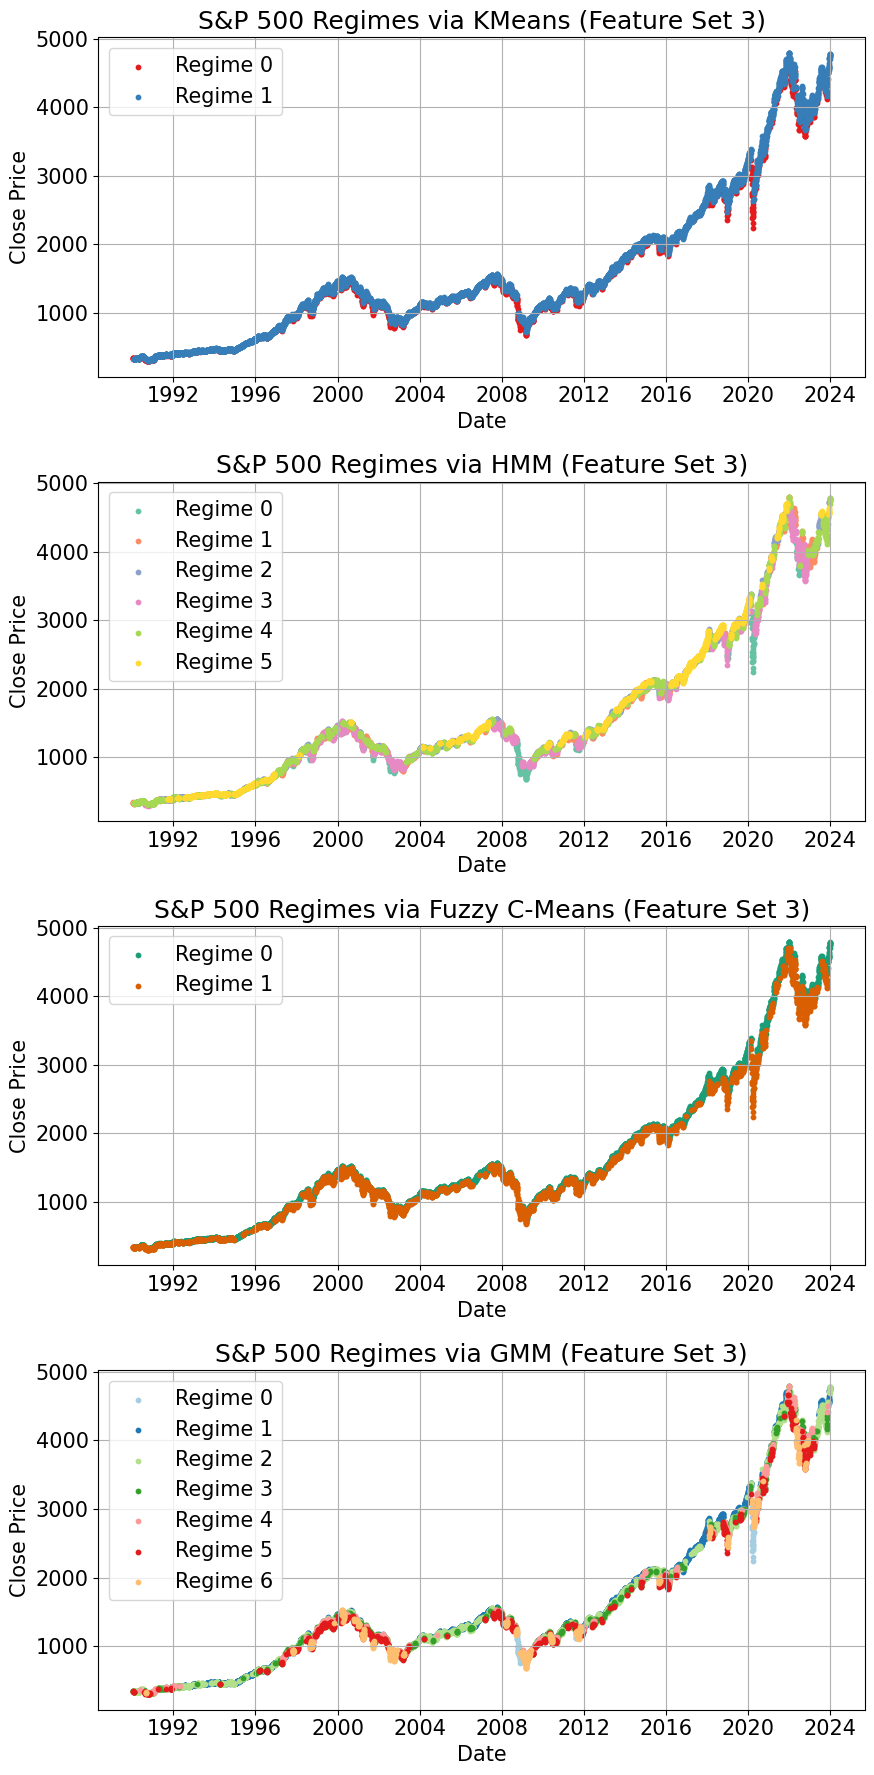

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(4, 1, figsize=(9, 18))
axs = axs.flatten()  # Flatten the 2x2 axes for easy looping

# Define clustering columns and titles
regime_columns = [
    ('Regime_KMeans', 'KMeans (Feature Set 3)', "Set1"),
    ('Regime_HMM', 'HMM (Feature Set 3)', "Set2"),
    ('Regime_FCM', 'Fuzzy C-Means (Feature Set 3)', "Dark2"),
    ('Regime_GMM', 'GMM (Feature Set 3)', "Paired"),
]

for ax, (col, title, palette_name) in zip(axs, regime_columns):
    unique_regimes = sorted(df_fs3[col].dropna().unique())
    palette = sns.color_palette(palette_name, len(unique_regimes))
    color_map = {regime: palette[i] for i, regime in enumerate(unique_regimes)}

    for regime in unique_regimes:
        regime_data = df_fs3[df_fs3[col] == regime]
        ax.scatter(regime_data.index, regime_data['Price'],
                   color=color_map[regime], label=f'Regime {regime}', s=10)

    ax.set_title(f"S&P 500 Regimes via {title}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Optional

Here, we explored a potential next step, a dashboard that presents buy-sell-signals and change points.

In [100]:
!pip install arch xgboost ruptures plotly


###  Regime Detection Dashboard

This integrated dashboard includes:

- **KMeans** clustering on returns, volatility, and momentum.
- **GARCH(1,1)** rolling volatility forecasts.
- **XGBoost**-based signal probability scores.
- **Change point detection** via Binary Segmentation.

**Interactive Plotly View**: Price movements, clustering regimes, forecasted volatilities, signal scores, and structural breaks in one glance.

In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from arch import arch_model
from xgboost import XGBClassifier
import ruptures as rpt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# --- Simulated S&P 500 Price Data (replace with your actual price data if needed) ---
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=500)
price = np.cumsum(np.random.randn(500)) + 3000
df = pd.DataFrame({"Price": price}, index=dates)

# --- Feature Engineering: Feature Set 3 ---
df['Return'] = df['Price'].pct_change()
df['Volatility'] = df['Return'].rolling(window=10).std()
df['Momentum'] = df['Price'].pct_change(periods=10)
df.dropna(inplace=True)

# --- KMeans Clustering ---
features = df[['Return', 'Volatility', 'Momentum']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

best_score = -1
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = km

df['Regime_KMeans'] = best_kmeans.predict(X_scaled)

# --- Rolling GARCH Forecast (per day using 50-day window) ---
df['GARCH_Forecast'] = np.nan
for i in range(50, len(df)):
    window_returns = df['Return'].iloc[i-50:i] * 100
    am = arch_model(window_returns, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    forecast = res.forecast(horizon=1).variance.iloc[-1, 0] / 10000
    df.loc[df.index[i], 'GARCH_Forecast'] = forecast

# --- XGBoost Signal Scoring ---
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)
X_model = df[['Return', 'Volatility', 'Momentum', 'GARCH_Forecast']].dropna()

if len(X_model) > 100:
    y_model = df.loc[X_model.index, 'Target']
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_model, y_model)
    df.loc[X_model.index, 'SignalScore'] = model.predict_proba(X_model)[:, 1]
else:
    print("[WARN] Not enough data for XGBoost training")

# --- Change Point Detection using Binary Segmentation ---
signal = df['Return'].dropna().values
algo = rpt.Binseg(model="l2").fit(signal)
change_points = algo.predict(n_bkps=5)
cp_dates = df.iloc[change_points[:-1]].index

# --- Plotly Dashboard ---
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=[
    "Price with KMeans Regimes",
    "GARCH Forecast Volatility (Rolling)",
    "XGBoost Signal Score",
    "Detected Change Points"
])

# 1. Price + Regimes
for regime in df['Regime_KMeans'].unique():
    idx = df[df['Regime_KMeans'] == regime].index
    fig.add_trace(go.Scatter(x=idx, y=df.loc[idx, 'Price'],
                             mode='markers', name=f'Regime {regime}',
                             marker=dict(size=3)), row=1, col=1)

# 2. GARCH Forecast
fig.add_trace(go.Scatter(x=df.index, y=df['GARCH_Forecast'],
                         mode='lines', name='GARCH Vol Forecast'), row=2, col=1)

# 3. XGBoost Signal Score
fig.add_trace(go.Scatter(x=df.index, y=df['SignalScore'],
                         mode='lines', name='Buy/Sell Signal'), row=3, col=1)

# 4. Change Points + Price
fig.add_trace(go.Scatter(x=df.index, y=df['Price'],
                         mode='lines', name='Price'), row=4, col=1)
for cp in cp_dates:
    fig.add_vline(x=cp, line=dict(color='red', dash='dash'), row=4, col=1)

fig.update_layout(height=1000, title_text="Market Regime Detection Dashboard with GARCH, XGBoost, and Change Points")
fig.show()
